In [2]:
import ot
import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt

In [3]:
def gaussian_basis(grid, center, sigma=0.2):
    diff = grid - center
    dist_sq = jnp.sum(diff**2, axis=-1)
    return jnp.exp(-dist_sq / (2 * sigma**2))

def evaluate_gaussians_on_grid(centers, grid, sigma=0.2):
    vmapped = jax.vmap(
        jax.vmap(lambda c: gaussian_basis(grid, c, sigma), in_axes=0),  # over points
        in_axes=0,  # over batch
    )
    return vmapped(centers)

In [4]:
grid_size = 10    

x = jnp.linspace(-1.5, 1.5, grid_size)
y = jnp.linspace(-1.5, 1.5, grid_size)
z = jnp.linspace(-1.5, 1.5, grid_size)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")
grid = jnp.stack([X, Y, Z], axis=-1) 

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
num_points = 4
sigma = 0.2


key = jax.random.PRNGKey(2)
points_gt = jax.random.uniform(key, (num_points, 3), minval=-1.0, maxval=1.0)
volume_gt = jnp.sum(
    jax.vmap(lambda c: gaussian_basis(grid, c, sigma))(points_gt), axis=0
)

noise_level = 0.1
noise_points = noise_level*jax.random.uniform(key, (num_points, 3), minval=-1.0, maxval=1.0)
points_estimate = points_gt + noise_points


def compute_volume_given_deformation_field(deformation_field):
    values = jnp.sum(
        jax.vmap(lambda c: gaussian_basis(grid, c, sigma))(points_estimate - deformation_field), axis=0
    )
    return values

volume_estimate = compute_volume_given_deformation_field(jnp.zeros_like(points_estimate))

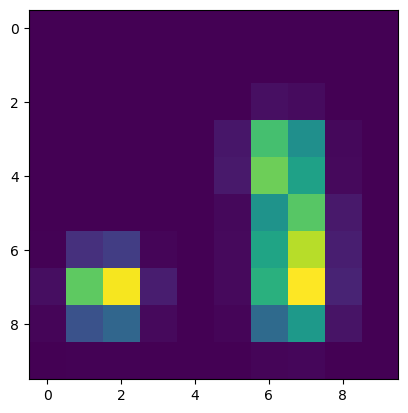

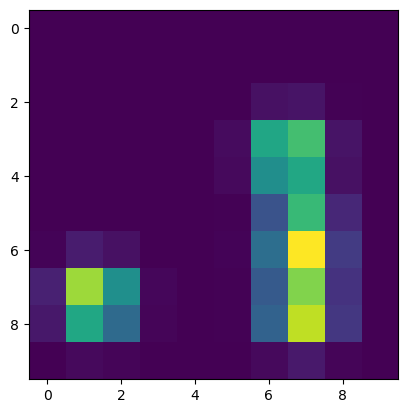

In [6]:
plt.imshow(volume_gt.sum(0))
plt.show()
plt.imshow(volume_estimate.sum(0))

In [7]:
# Replace your current line with:
a = grid.reshape(-1, 3)
b = grid.reshape(-1, 3)
cost = jnp.linalg.norm(a[:, None, :] - b[None, :, :], axis=-1)
cost /= jnp.max(cost)

In [8]:
normalized_marginal_t = volume_gt.flatten() / jnp.sum(volume_gt)
normalized_marginal_s = volume_estimate.flatten() / jnp.sum(volume_estimate)

emd_loss = ot.emd2(normalized_marginal_t, normalized_marginal_s, cost, numItermax=100000)

In [14]:
n_steps = 100

deformation_field = jnp.zeros_like(points_estimate)
losses = []
accuracy_list = []
emd_losses = []
for i in range(n_steps):
    if i % 10 == 0:
        print(f"Step {i}, EMD Loss: {emd_loss}")
    volume_estimate = compute_volume_given_deformation_field(deformation_field)
    normalized_marginal_s = volume_estimate.flatten() / jnp.sum(volume_estimate)
    emd_loss = ot.emd2(normalized_marginal_t, normalized_marginal_s, cost, numItermax=100000)
    emd_losses.append(emd_loss)
     # gradient descent on deformation field
    # emd_grad = jax.grad(lambda df: ot.emd2(normalized_marginal_t, normalized_marginal_s, cost, numItermax=100000))(deformation_field)
    mse_grad = jax.grad(lambda df: jnp.linalg.norm(compute_volume_given_deformation_field(df) - volume_gt))(
        deformation_field
    )
    deformation_field -= 0.001 * mse_grad

    loss = jnp.linalg.norm(compute_volume_given_deformation_field(deformation_field) - volume_gt)
    losses.append(loss)
    accuracy = jnp.linalg.norm(-noise_points - deformation_field)
    accuracy_list.append(accuracy)

Step 0, EMD Loss: 0.026307178661227226
Step 10, EMD Loss: 0.022825170308351517
Step 20, EMD Loss: 0.018911441788077354
Step 30, EMD Loss: 0.014982803724706173
Step 40, EMD Loss: 0.01104319840669632


/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Step 50, EMD Loss: 0.008684070780873299


/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning:

Step 60, EMD Loss: 0.004365308675915003


/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Step 70, EMD Loss: 0.0002874504425562918
Step 80, EMD Loss: 0.00019527027325239033
Step 90, EMD Loss: 0.00016124924877658486


In [ ]:
n_steps = 100

deformation_field = jnp.zeros_like(points_estimate)
losses = []
accuracy_list = []
emd_losses = []

def emd_loss_fn(df):
    volume_estimate = compute_volume_given_deformation_field(df)
    normalized_marginal_s = volume_estimate.flatten() / jnp.sum(volume_estimate)
    return ot.emd2(normalized_marginal_t, normalized_marginal_s, cost, numItermax=100000)

for i in range(n_steps):
    emd_loss = emd_loss_fn(deformation_field)
    if i % 10 == 0:
        print(f"Step {i}, EMD Loss: {emd_loss}")
    emd_losses.append(emd_loss)

    # Gradient descent step
    emd_grad = jax.grad(emd_loss_fn)(deformation_field)
    deformation_field -= 0.001 * emd_grad

    # Compute loss and accuracy
    volume_estimate = compute_volume_given_deformation_field(deformation_field)
    loss = jnp.linalg.norm(volume_estimate - volume_gt)
    losses.append(loss)
    accuracy = jnp.linalg.norm(noise_points - deformation_field)
    accuracy_list.append(accuracy)

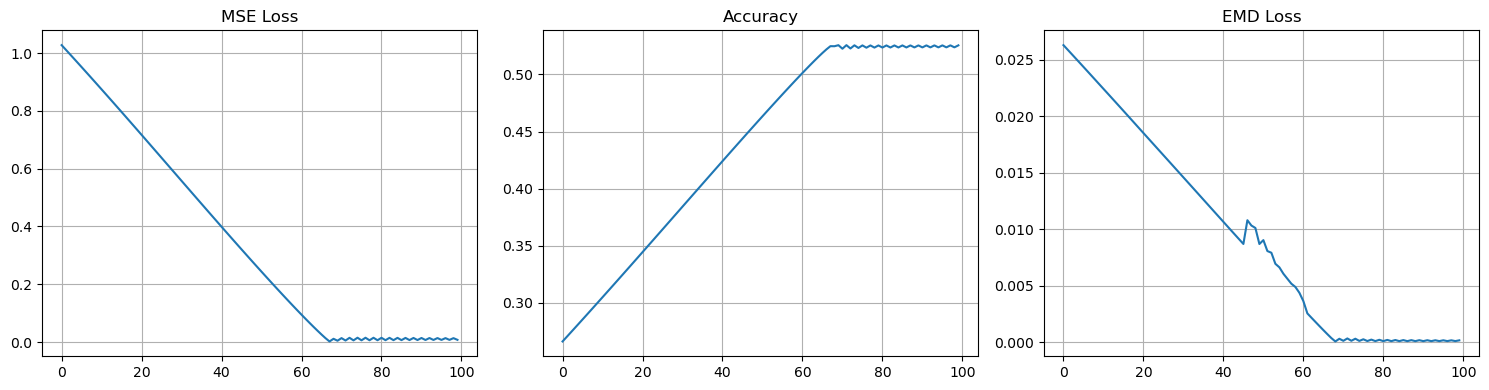

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(losses)
axs[0].set_title("MSE Loss")

axs[1].plot(accuracy_list)
axs[1].set_title("Accuracy")

axs[2].plot(emd_losses)
axs[2].set_title("EMD Loss")

for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()

# pytorch

In [ ]:
import torch
import ot
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Setup inputs in PyTorch ---

# Convert JAX arrays to numpy, then to torch
points_estimate_torch = torch.tensor(np.array(points_estimate), dtype=torch.float32, device=device)
volume_gt_torch = torch.tensor(np.array(volume_gt), dtype=torch.float32, device=device)
noise_points_torch = torch.tensor(np.array(noise_points), dtype=torch.float32, device=device)
grid_torch = torch.tensor(np.array(grid), dtype=torch.float32, device=device)
cost_torch = torch.tensor(np.array(cost), dtype=torch.float32, device=device)
normalized_marginal_t_torch = torch.tensor(np.array(normalized_marginal_t), dtype=torch.float32, device=device)

# --- Helper functions ---

def gaussian_basis(grid, center, sigma=0.2):
    diff = grid - center
    dist_sq = torch.sum(diff ** 2, dim=-1)
    return torch.exp(-dist_sq / (2 * sigma ** 2))

def compute_volume_given_deformation_field(deformation_field, points_estimate, grid, sigma=0.2):
    values = torch.stack([
        gaussian_basis(grid, c, sigma) for c in (points_estimate - deformation_field)
    ], dim=0).sum(dim=0)
    return values



Step 0, EMD Loss: 0.026307178661227226
Step 10, EMD Loss: 0.022847291082143784
Step 20, EMD Loss: 0.01941809616982937
Step 30, EMD Loss: 0.01606600359082222
Step 40, EMD Loss: 0.01291174441576004
Step 50, EMD Loss: 0.009928764775395393
Step 60, EMD Loss: 0.006963625084608793
Step 70, EMD Loss: 0.004638045094907284
Step 80, EMD Loss: 0.0023491396568715572
Step 90, EMD Loss: 0.0004502783122006804
Step 100, EMD Loss: 0.0005127538461238146
Step 110, EMD Loss: 0.00021068527712486684
Step 120, EMD Loss: 0.00010890145495068282
Step 130, EMD Loss: 4.495673783821985e-05
Step 140, EMD Loss: 4.361145693110302e-05
Step 150, EMD Loss: 4.200713010504842e-05
Step 160, EMD Loss: 1.9133083696942776e-05
Step 170, EMD Loss: 1.8046261175186373e-05
Step 180, EMD Loss: 2.6054018235299736e-05
Step 190, EMD Loss: 3.960528920288198e-05


Step 0, EMD Loss: 0.026307178661227226
Step 10, EMD Loss: 0.02284873276948929
Step 20, EMD Loss: 0.019429156556725502
Step 30, EMD Loss: 0.016105126589536667
Step 40, EMD Loss: 0.01290694810450077
Step 50, EMD Loss: 0.009962244890630245
Step 60, EMD Loss: 0.007151775062084198
Step 70, EMD Loss: 0.004454350098967552
Step 80, EMD Loss: 0.002220769412815571
Step 90, EMD Loss: 0.00012348969175945967
Step 100, EMD Loss: 0.0005260092439129949
Step 110, EMD Loss: 0.0002414906193735078
Step 120, EMD Loss: 0.00013434977154247463
Step 130, EMD Loss: 3.526835280354135e-05
Step 140, EMD Loss: 2.241584297735244e-05
Step 150, EMD Loss: 4.215654553263448e-05
Step 160, EMD Loss: 3.606841710279696e-05
Step 170, EMD Loss: 2.1953805116936564e-05
Step 180, EMD Loss: 1.1917425581486896e-05
Step 190, EMD Loss: 2.9498685762519017e-05


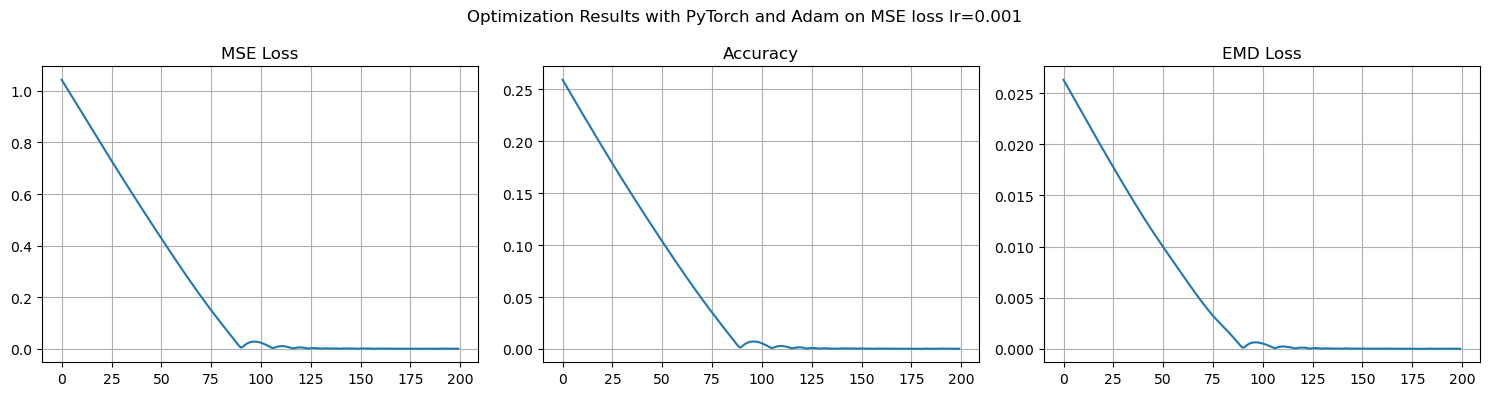

In [45]:
# --- Optimization loop ---

n_steps = 200

deformation_field = torch.zeros_like(points_estimate_torch, requires_grad=True)
mse_losses = []
accuracy_list = []
emd_losses = []

lr = 0.001  # Learning rate for SGD
optimizer = torch.optim.Adam([deformation_field], lr=lr)

for i in range(n_steps):
    optimizer.zero_grad()
    volume_estimate = compute_volume_given_deformation_field(deformation_field, points_estimate_torch, grid_torch)
    normalized_marginal_s = volume_estimate.flatten() / volume_estimate.sum()
    # Convert to numpy for POT
    emd_loss = ot.emd2(
        normalized_marginal_t_torch,
        normalized_marginal_s,
        cost_torch,
        numItermax=100000
    )
    if i % 10 == 0:
        print(f"Step {i}, EMD Loss: {emd_loss}")
    emd_losses.append(emd_loss.item())

    # Backprop through MSE loss (since ot.emd2 is not differentiable)
    mse_loss = torch.norm(volume_estimate - volume_gt_torch)
    mse_loss.backward()
    optimizer.step()

    mse_losses.append(mse_loss.item())
    accuracy = torch.norm(noise_points_torch - deformation_field).item()
    accuracy_list.append(accuracy)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mse_losses)
axs[0].set_title("MSE Loss")

axs[1].plot(accuracy_list)
axs[1].set_title("Accuracy")

axs[2].plot(emd_losses)
axs[2].set_title("EMD Loss")

for ax in axs:
    ax.grid(True)

fig.suptitle(f"Optimization Results with PyTorch and Adam on MSE loss lr={lr}")
plt.tight_layout()
plt.show()

Step 0, EMD Loss: 0.026307178661227226
Step 10, EMD Loss: 0.022847291082143784
Step 20, EMD Loss: 0.01941809616982937
Step 30, EMD Loss: 0.01606600359082222
Step 40, EMD Loss: 0.01291174441576004
Step 50, EMD Loss: 0.009928764775395393
Step 60, EMD Loss: 0.006963625084608793
Step 70, EMD Loss: 0.004638045094907284
Step 80, EMD Loss: 0.0023491396568715572
Step 90, EMD Loss: 0.0004502783122006804
Step 100, EMD Loss: 0.0005127538461238146
Step 110, EMD Loss: 0.00021068527712486684
Step 120, EMD Loss: 0.00010890145495068282
Step 130, EMD Loss: 4.495673783821985e-05
Step 140, EMD Loss: 4.361145693110302e-05
Step 150, EMD Loss: 4.200713010504842e-05
Step 160, EMD Loss: 1.9133083696942776e-05
Step 170, EMD Loss: 1.8046261175186373e-05
Step 180, EMD Loss: 2.6054018235299736e-05
Step 190, EMD Loss: 3.960528920288198e-05


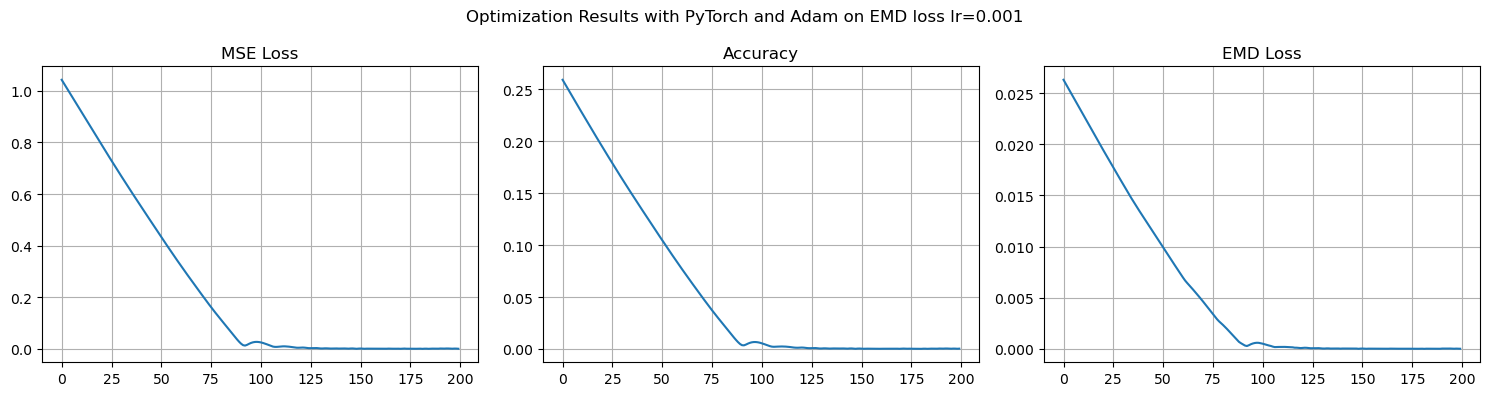

In [ ]:
# --- Optimization loop ---

n_steps = 200

deformation_field = torch.zeros_like(points_estimate_torch, requires_grad=True)
mse_losses = []
accuracy_list = []
emd_losses = []

lr = 0.001  # Learning rate for SGD
optimizer = torch.optim.Adam([deformation_field], lr=lr)

for i in range(n_steps):
    optimizer.zero_grad()
    volume_estimate = compute_volume_given_deformation_field(deformation_field, points_estimate_torch, grid_torch)
    normalized_marginal_s = volume_estimate.flatten() / volume_estimate.sum()
    # Convert to numpy for POT
    emd_loss = ot.emd2(
        normalized_marginal_t_torch,
        normalized_marginal_s,
        cost_torch,
        numItermax=100000
    )
    if i % 10 == 0:
        print(f"Step {i}, EMD Loss: {emd_loss}")
    emd_losses.append(emd_loss.item())

    # Backprop through MSE loss (since ot.emd2 is not differentiable)
    mse_loss = torch.norm(volume_estimate - volume_gt_torch)
    emd_loss.backward()
    optimizer.step()

    mse_losses.append(mse_loss.item())
    accuracy = torch.norm(noise_points_torch - deformation_field).item()
    accuracy_list.append(accuracy)



fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mse_losses)
axs[0].set_title("MSE Loss")

axs[1].plot(accuracy_list)
axs[1].set_title("Accuracy")

axs[2].plot(emd_losses)
axs[2].set_title("EMD Loss")

for ax in axs:
    ax.grid(True)

fig.suptitle(f"Optimization Results with PyTorch and Adam on EMD loss lr={lr}")
plt.tight_layout()
plt.show()